In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from sklearn.cluster import DBSCAN
import cv2

In [9]:
def diffusion(img,it=10,gamma=.1,k=40,sigma=1,step=(1.,1.)):
    '''
    x = img.copy()
    for i in range(iterations):
        J = np.zeros((x.shape[0],x.shape[1],2))
        J[1:,:,1] = np.diff(x, axis=0)
        J[:,1:,0] = np.diff(x, axis=1)
        tmp = np.reshape(np.sqrt(np.sum(J**2,axis=-1)),(J.shape[0],-1,1))
        J_parallel = J/np.where(tmp==0,1,tmp)
        J_vertical = J*0
        J_vertical[...,0] = J_parallel[...,1]
        J_vertical[...,1] = -J_parallel[...,0]
        
        across_edge_factor = 1/(1+(tmp[:,:,0]/10)**2)
        along_edge_factor = 1
        D = np.zeros((x.shape[0],x.shape[1],3))
        D[...,0] = across_edge_factor*J_parallel[...,0]**2+along_edge_factor*J_vertical[...,0]**2
        D[...,1] = across_edge_factor*J_parallel[...,0]*J_parallel[...,1]+along_edge_factor*J_vertical[...,0]*J_vertical[...,1]
        D[...,2] = across_edge_factor*J_parallel[...,1]**2+along_edge_factor*J_vertical[...,1]**2

        h1 = 1
        h2 = 1
        result = x[:-2,:-2]*((-D[1:-1,:-2,1]-D[2:,1:-1,1])/(4*h1*h2))+\
        x[:-2,1:-1]*((D[2:,1:-1,2]+D[1:-1,1:-1,2])/(2*h2**2))+\
        x[:-2,2:]*((D[1:-1,2:,1]+D[2:,1:-1,1])/(4*h1*h2))+\
        x[1:-1,:-2]*((D[1:-1,:-2,0]+D[1:-1,1:-1,0])/(2*h1**2))+\
        x[1:-1,1:-1]*((-D[1:-1,:-2,0]-2*D[1:-1,1:-1,0]-D[1:-1,2:,0])/(2*h1**2)+(-D[:-2,1:-1,2]-2*D[1:-1,1:-1,2]-D[2:,1:-1,2])/(2*h2**2))+\
        x[1:-1,2:]*((D[1:-1,2:,0]+D[1:-1,1:-1,0])/(2*h1**2))+\
        x[2:,:-2]*((D[1:-1,:-2,1]+D[:-2,1:-1,1])/(4*h1*h2))+\
        x[2:,1:-1]*((D[:-2,1:-1,2]+D[1:-1,1:-1,2])/(2*h2**2))+\
        x[2:,2:]*((-D[1:-1,2:,1]-D[:-2,1:-1,1])/(4*h1*h2))  

        x[1:-1,1:-1] += result*0.2'''
    imgout = img.copy()
    h,w = imgout.shape
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()
    deltaSf = deltaS.copy()
    deltaEf = deltaS.copy()
    x = int(sigma*2 + 1)
    if(x%2==0):
        x = x- 1;
    for ii in range(it):
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)
        if 0<sigma:
            gauss = cv2.GaussianBlur(imgout,(x,x),0)
            deltaSf[:-1,:] = np.diff(gauss,axis=0)
            deltaEf[:,:-1] = np.diff(gauss,axis=1)
        else:
            deltaSf=deltaS;
            deltaEf=deltaE;
        deltaSf[deltaSf<1] = 1
        deltaEf[deltaEf<1] = 1
        gS = 1. - np.exp(-3.31588/((deltaSf/k)**4))
        gE = 1. - np.exp(-3.31588/((deltaEf/k)**4))   
        E = gE*deltaE
        S = gS*deltaS
        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]
        imgout += gamma*(NS+EW)  
    return imgout

In [10]:
#resize to 0.1
x = Image.open('mouse.tif')
x = x.resize(np.array(x.size)//10,0)
x = np.array(x).astype(float)
x -= np.min(x)
x /= np.max(x)

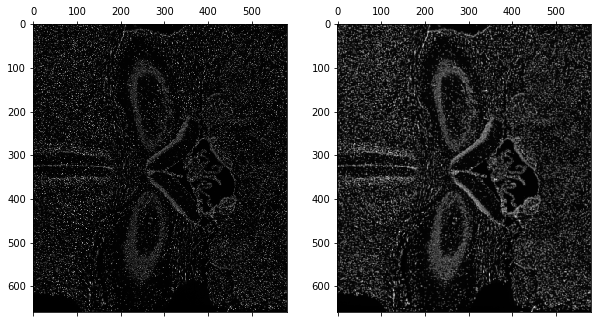

In [90]:
#when iteration=1, it gets a better seperation when I tried.
y = diffusion(x,it=1,k=4,sigma=1,gamma=0.25)
plt.figure(figsize=(10,12))
plt.subplot(121).matshow(x,cmap='gray')
plt.subplot(122).matshow(y,cmap='gray')

5393


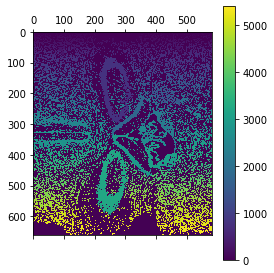

In [92]:
x1 = y>0.047
dbscn_x = []
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        if x1[i,j]==1:
            dbscn_x.append([i,j])
dbscn_x = np.array(dbscn_x)
db = DBSCAN(eps=1.3, min_samples=5).fit(dbscn_x)
print(np.max(db.labels_))
x2 = x1*0-5
ef = 0
for i in range(len(dbscn_x)):
    x2[dbscn_x[i][0],dbscn_x[i][1]]=db.labels_[i]
plt.matshow(x2)
plt.colorbar()

7923


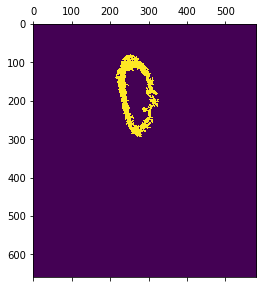

2549


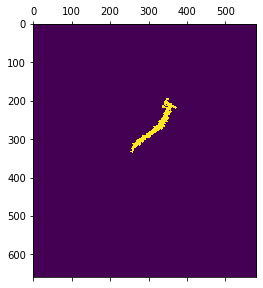

2592


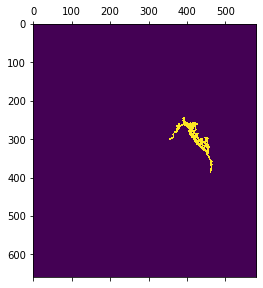

3639


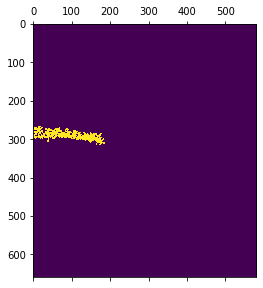

3152


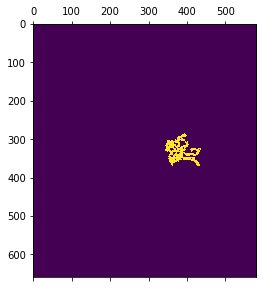

3823


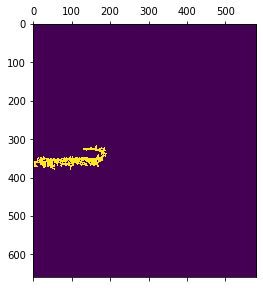

2841


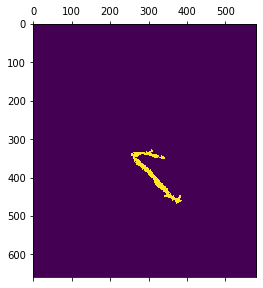

3815


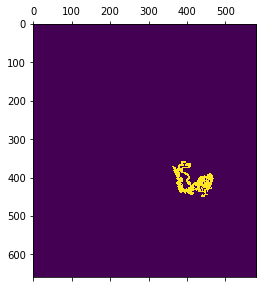

9059


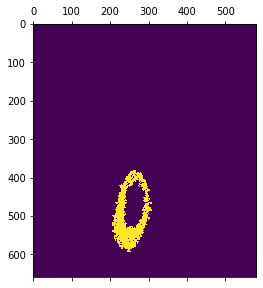

In [96]:
q = x2*0-1
lb = 4
for i in range(np.max(db.labels_)):
    if np.sum(x2==i)>2500:
        print(np.sum(x2==i))
        plt.matshow(x2==i)
        plt.show()
        q+=(x2==i)*lb
        lb+=1

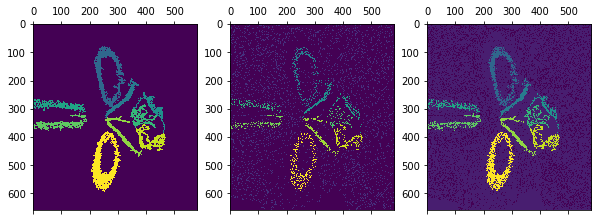

In [97]:
plt.figure(figsize=(10,12))
#class mask
plt.subplot(131).matshow(q)
#mask*cells+background cells, I set cell threshold with 0.15, below it will be iignored as noise.
#Background cells are classified into one category, since it is less attracting.
#A population of cells, whcih clustered into typical structure, will categoried into one class.
plt.subplot(132).matshow((q+(x>0.15)*3)*(x>0.15))
#combined with original picture
plt.subplot(133).matshow((q*(x>0.07)))